In [18]:
# stuff from Google interview

import pandas as pd
import numpy  as np
import math
import matplotlib.pyplot as plt
%matplotlib inline


In [299]:

# construct fake data of the form discussed; a data frame with group, user, and time columns
# and a unique user-group relationship for any data point. find per-user durations from the table
# and group mean durations

# first, create some fake data and the "ground truth" against which to compare pandas
# native operations

G = 10 # number of groups
U = 1000 # number of users

# random sample of user-group assignments
gr = np.append( np.sort( np.random.rand( G-1 ) , axis=0 ) , [1.0] ) # random "buckets" for groups, in increasing order
ur = np.random.rand( U ) # random "values" for users, in increasing order
ug = np.argmax( ( ur.reshape((U,1)) < gr.reshape((1,G))  ) , axis=1 ) + 1 # group assignment indices
el = np.random.poisson( lam=10.0 , size=U ) + 2 # elements per user
N = np.sum( el ) # total number of rows (observations) equal to total number of elements
D = np.empty( (N,3) )
b = 0
ut = np.empty( U )
gt = np.zeros( G )
gu = np.zeros( G )
for u in range(0,U) :
    c = b + el[u]
    D[b:c,0] = ug[u]
    D[b:c,1] = u + 1
    t = np.random.rand( el[u] )
    D[b:c,2] = t.copy()
    ut[u] = np.max( t ) - np.min( t )
    gt[ ug[u]-1 ] += ut[u]
    gu[ ug[u]-1 ] += 1
    b = c
    
gt = gt / gu # normalize averages

DF = pd.DataFrame( data=D , columns=['group','user','time'] , copy=True ) # create the dataframe
DF = DF.sort_values( by=['time'], ascending=[True] ) # sort by time, mimicking a stream-like table

# now we have this data frame... do the aggregations in pandas-native operations
gdf = DF.groupby( by=['user','group'] , sort=True ) # groupby order is important
gut = gdf.agg( { 'time' : [np.max,np.min] } , as_index=False ) # aggregate 'time' column by min and max
gut['dur'] = gut['time','amax'] - gut['time','amin'] # add a duration column

# check answer for first part: user durations
print( 'this should print zero if user durations are correct: ' , np.max( np.abs( gut['dur'].values - ut ) ) )

# second part: compute means
gat = gut['dur'].groupby( level=[1] ).mean() # note level "1" from ordering before

# check answer for second part: within group mean user durations
print( 'this should print zero if group mean durations are correct: ' , np.max( np.abs( gat.values - gt ) ) )


this should print zero if user durations are correct:  0.0
this should print zero if group mean durations are correct:  0.0


2.71836 {1: 0.50114, 2: 0.33105, 3: 0.12579, 4: 0.03408, 5: 0.00641, 6: 0.00134, 7: 0.00018, 8: 1e-05}
2.71836 2.71963
exact mean:  2.718281828459045 2.71827876984127 simulated mean(s):  2.71836 2.71963


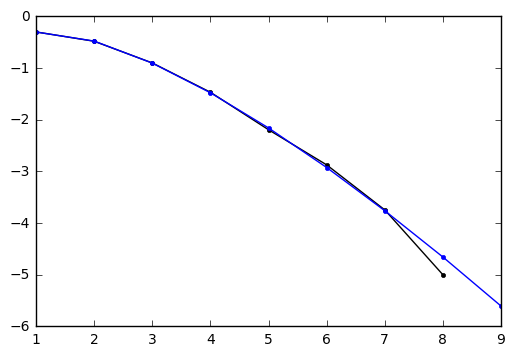

In [58]:
# Given a sequence X_1,X_2,... ~ U(0,1) of iid standard uniform variables, let 
# 
#      N = min{ n : X_n < X_{n-1} }
# 
# What is Expect[ N ]? 
# 
# The simulation approach is straightforward, as coded below. Note we use C/C++/python-style 
# 0-base indexing not math/FORTRAN/matlab-style 1-base indexing. 

def simulate(  ) : 
    """ simulate a sequence of iid U(0,1) variables, and return the index of first decrease """
    S = np.random.rand( 50 )
    D = ( S[1:] - S[0:-1] < 0 ).astype( np.uint8 )
    return np.argmax( D ) + 1

T = 100000
Ns = {}
for n in range(0,T) : 
    N = simulate(  )
    if N in Ns : Ns[N] += 1
    else : Ns[N] = 1

m = 0
for N in Ns : 
    Ns[N] /= T
    m += Ns[N] * (N+1) # times N+1 because of zero-based indexing

print( m , Ns )

N = np.array( list( Ns.keys()   ) )
C = np.array( list( Ns.values() ) )
plt.plot( N , np.log10(C) , '.-k' )

# here is a no-(explicit-)loop method
S = np.random.rand(50,T).astype( np.float32 )
D = ( S[1:,:] - S[0:-1,:] < 0 ).astype( np.uint8 )
N = np.argmax( D , axis=0 ) + 2
m2 = np.mean( N )

print( m , m2 )

# Can we come up with an EXACT computation? I think so: my guess is that 
# 
#     Prob( X_1 <= X_2 <= ... <= X_n ) 
#          = \int_0^1 \int_0^{x_n} ... \int_0^{x_2} dx_1 ... dx_{n-1} dx_n
#          = 1/n!
# 
# as can be shown via induction, technically over 
# 
#     \int_0^{x} ... \int_0^{x_2} dx_1 ... dx_{n-1} = x^{n-1} / (n-1)!
# 
# This is useful because 
# 
#     Prob( N <= n ) = 1 - Prob( X_1 <= X_2 <= ... <= X_n ) = 1 - 1/n!
# 
# and thus
# 
#     Prob( N == n ) = 1/(n-1)! - 1/(n-1)! = (1/n)(1/(n-2)!)
# 
# for n >= 2, which implies
# 
#     Expect[N] = sum_{n=2}^\infty n Prob( N == n )
#               = sum_{n=2}^\infty 1/(n-2)!
#               = sum_{n=0}^\infty 1/n!
#               = e (cool)
# 
# This can be approximated directly, at least, by accumulating terms. Say we accumulate
# up to term M; then our (absolute) error is less than 1/(M-2)!. Let's say we stop when 
# our error is <= 1.0e-6, and thus (M-2)! >= 1.0e6. Hence we should compute up to M = 11
# ( 9! = (11-2)! < 1e6, but 10! = (12-2)! > 1e6 ). But... why?
Ns = np.arange(1,10,1) # {1,...,10} (zero-base indexing)
Ps = np.zeros(10) 
EN = 0 # initialize accumulated expectation sum
f  = 1.0 # running factorial of n-1 (in base zero)
for n in range(1,10) : 
    F     = 1.0 / math.factorial(n-1)
    np1   = n + 1
    Ps[n] = F / np1
    EN   += F # == Ps[n] * np1
    f     = f * np1
print( 'exact mean: ' , math.exp(1) , EN , 'simulated mean(s): ' , m , m2 )
    
plt.plot( Ns , np.log10(Ps[1:]) , '.-b' )


In [44]:
import math

math.factorial( 9 ) - 1.0e6

-637120.0

In [64]:
# Say we take N (odd) bernoulli trials but stop when "heads" or "tails" comes up N - floor(N/2)
# times. What is the probability of having a sequence of length N? I solve this both with an
# method and a simulation method, which compute the probability mass function of the outcome
# variable(s) (W,L) where W is the winner and L is the (stopped) sequence length. If we just
# want the probability of full sequences, we can compute the marginal mass of L == N via addition. 

def bestof_exact( N , prob=0.5 , size=None ) : 
    
    """ compute exact "best of" probabilities for a bernoulli variable with parameter p """
    
    from scipy.special import binom
    
    if N % 2 == 0 : raise ValueError( 'best of requires an odd number of trials' )
    
    # initialize stuff we use below
    w = int((N+1)/2) # win count
    r = N-w     # remainder
    p = min( max( prob , 0.0 ) , 1.0 ) # "target" probability (safegaurded)
    q = 1.0-p   # "alternative" probability
    
    # eliminate trivial cases
    if ( p == 1.0 ) or ( p == 0.0 ) :
        A , B = np.zeros( w ) , np.zeros( w )
        if p == 1.0 : A[0] = 1.0
        else: B[0] = 1.0
        return ( A , B )
    
    # allocate space
    A , B = np.zeros( w ) , np.zeros( w )
    
    # compute probabilities
    for i in range(0,w) : 
        # initialize this element with truncated binomial probability
        c = binom( w+i , w )
        A[i] , B[i] = c * p**w * q**i , c * p**i * q**w
        if i > 0 : # subtract out a fraction of the last "branch" in the sequence tree
            A[i] -= q * A[i-1]
            B[i] -= p * B[i-1]
    
    return (A,B)

def bestof_simul( N , prob=0.5 , size=1000 ) : 
    
    """ simulate "best of" probabilities for a bernoulli variable with parameter p """
    
    if N % 2 == 0 : raise ValueError( 'best of requires an odd number of trials' )
    
    # initialize stuff we use below
    w = int((N+1)/2) # win count
    p = min( max( prob , 0.0 ) , 1.0 ) # "target" probability (safegaurded)
    
    # eliminate trivial cases
    if ( p == 1.0 ) or ( p == 0.0 ) :
        A , B = np.zeros( w ) , np.zeros( w )
        if p == 1.0 : A[0] = 1.0
        else: B[0] = 1.0
        return ( A , B )
    
    # allocate space
    A , B , S = np.empty( w ) , np.empty( w ) , np.empty( N )
    
    # simulate
    for s in range(0,size) : 
        
        # draw a sequence, compute length and figure out winner
        S = np.cumsum( np.random.rand( N ) <= p )
        if S[-1] >= w : # target wins
            i = w-1
            while S[i] < w : i += 1
            A[i-w+1] += 1
        else : # alternative wins
            S = np.arange( 1 , N+1 , 1 ) - S
            i = w-1
            while S[i] < w : i += 1
            B[i-w+1] += 1
    
    # normalize for probabilities
    A /= size
    B /= size
    
    return (A,B)

def bestof( N , prob=0.5 , exact=True , size=1000 ) : 
    if exact : return bestof_exact( N , prob=prob , size=None )
    else     : return bestof_simul( N , prob=prob , size=size )

# problem: given p and N state Prob( length == max )
def bestof_maxlength( N , prob=0.5 , exact=True , size=10000 ) :
    if exact : R = bestof_exact( N , prob=prob , size=None )
    else     : R = bestof_simul( N , prob=prob , size=size )
    return ( R[0][-1] + R[1][-1] )
    
def test_bestof( N , prob=0.5 , exact=True , size=1000 ) : 
    R = bestof( N , prob=prob , exact=exact , size=size )
    A , B = R[0] , R[1]
    print( 'probabilities: ' , A , B[::-1] , np.sum(A) + np.sum(B) )
    
N , p = 3 , 0.75
# test_bestof( N , prob=p , exact=True )
# test_bestof( N , prob=p , exact=False , size=10 )
# test_bestof( N , prob=p , exact=False , size=100 )
# test_bestof( N , prob=p , exact=False , size=1000 )
# test_bestof( N , prob=p , exact=False , size=10000 )
# test_bestof( N , prob=p , exact=False , size=100000 )
# test_bestof( N , prob=p , exact=False , size=1000000 )
# print( 'done testing' )

N , p = 3 , 0.5 # easy to compute: 50%
print( bestof_maxlength( N , prob=p , exact=True ) , bestof_maxlength( N , prob=p , exact=False ) )

N , p = 3 , 0.75 # easy to compute 37.5%
print( bestof_maxlength( N , prob=p , exact=True ) , bestof_maxlength( N , prob=p , exact=False ) )

N , p = 7 , 0.5 # possible analytical test case: should be "easy" to figure out? 
print( bestof_maxlength( N , prob=p , exact=True ) , bestof_maxlength( N , prob=p , exact=False ) )

N , p = 7 , 0.75 # harder to figure out, but nonetheless
print( bestof_maxlength( N , prob=p , exact=True ) , bestof_maxlength( N , prob=p , exact=False ) )
    

0.5 0.50145
0.375 0.3707375
0.375 0.3077375
0.158203125 0.136115820312
